In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
image_paths = {
    'healthy': '/content/drive/MyDrive/dataset4/healthy_segments',
    'brb': '/content/drive/MyDrive/dataset4/brb_segments',
    'brbl': '/content/drive/MyDrive/dataset4/brb_lite_segments',
    'ub': '/content/drive/MyDrive/dataset4/ub_segments',
    'gi': '/content/drive/MyDrive/dataset4/gi_segments',
    'sitsc': '/content/drive/MyDrive/dataset4/sitsc_segments'
}

feature_paths = {
    'healthy': '/content/drive/MyDrive/dataset4/healthy_features',
    'brb': '/content/drive/MyDrive/dataset4/brb_features',
    'brbl': '/content/drive/MyDrive/dataset4/brb_lite_features',
    'ub': '/content/drive/MyDrive/dataset4/ub_features',
    'gi': '/content/drive/MyDrive/dataset4/gi_features',
    'sitsc': '/content/drive/MyDrive/dataset4/sitsc_features'
}

In [ ]:
def load_images(folder, label):
    X = []
    y = []
    for fname in sorted(os.listdir(folder)):
        if fname.endswith('.png'):
            img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            X.append(img.flatten())
            y.append(label)
    return np.array(X), np.array(y)

def load_features(folder):
    feats = []
    for fname in sorted(os.listdir(folder)):
        if fname.endswith('.csv'):
            vec = np.loadtxt(os.path.join(folder, fname), delimiter=',')
            feats.append(vec)
    return np.array(feats)

In [ ]:
X_img_all = []
X_num_all = []
y_all = []

label_map = {'healthy':0, 'brb':1, 'brbl':2, 'ub':3, 'gi':4, 'sitsc':5}

for cls in ['healthy', 'brb', 'brbl', 'ub', 'gi', 'sitsc']:
    X_img, y = load_images(image_paths[cls], label_map[cls])
    X_num = load_features(feature_paths[cls])

    m = min(len(X_img), len(X_num))  # match lengths
    X_img_all.append(X_img[:m])
    X_num_all.append(X_num[:m])
    y_all.append(y[:m])

X_img_all = np.vstack(X_img_all)
X_num_all = np.vstack(X_num_all)
y_all = np.hstack(y_all)

print("Image data:", X_img_all.shape)
print("Numerical data:", X_num_all.shape)
print("Labels:", y_all.shape)


Image data: (4773, 16384)
Numerical data: (4773, 11)
Labels: (4773,)


In [ ]:
pca = PCA(n_components=100)
X_img_pca = pca.fit_transform(X_img_all)

print("PCA image features:", X_img_pca.shape)

PCA image features: (4773, 100)


In [ ]:
# Clean feature matrix
print("Before cleaning:", np.isfinite(X_num_all).all())

X_num_scaled = np.nan_to_num(
    X_num_all, nan=0.0, posinf=1e6, neginf=-1e6
)

print("After cleaning:", np.isfinite(X_num_scaled).all())


Before cleaning: False
After cleaning: True


In [ ]:
print("Max value in X_total:", X_num_scaled.max())
print("Min value in X_total:", X_num_scaled.min())


Max value in X_total: 1902.72898478304
Min value in X_total: -1000000.0


In [ ]:
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num_scaled)

In [ ]:
print("Max value in X_total:", X_num_scaled.max())
print("Min value in X_total:", X_num_scaled.min())

Max value in X_total: 18.682650918853994
Min value in X_total: -17.08592275985193


In [ ]:
X_total = np.hstack([X_img_pca, X_num_scaled])
print("Total multimodal features:", X_total.shape)

Total multimodal features: (4773, 111)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_all, test_size=0.2, stratify=y_all, random_state=42
)


In [25]:
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth= None,
    random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


RandomForest Accuracy = 0.9895287958115183


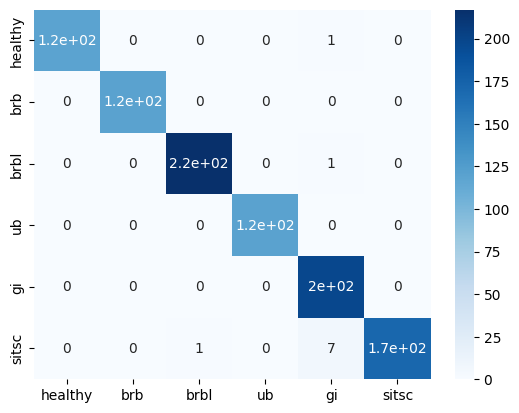

In [27]:
acc = accuracy_score(y_test, y_pred)
print("RandomForest Accuracy =", acc)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues',
            xticklabels=['healthy', 'brb', 'brbl', 'ub', 'gi', 'sitsc'],
            yticklabels=['healthy', 'brb', 'brbl', 'ub', 'gi', 'sitsc'])
plt.show()

SVM Accuracy = 0.9821989528795811


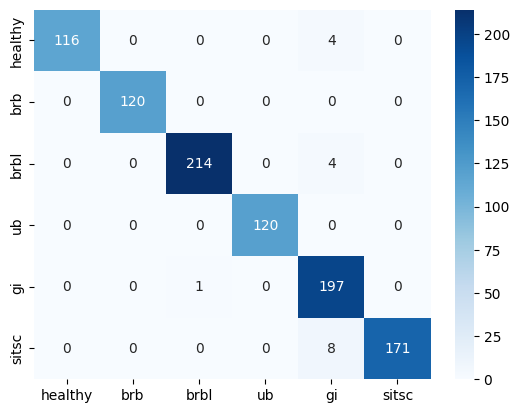

In [19]:
from sklearn.svm import SVC
clf = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

acc = accuracy_score(y_test, y_pred)
print("SVM Accuracy =", acc)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=['healthy', 'brb', 'brbl', 'ub', 'gi', 'sitsc'],
            yticklabels=['healthy', 'brb', 'brbl', 'ub', 'gi', 'sitsc'])
plt.show()